# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variatonal autoencoders combine neural networks with variationl inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Here's an example of what your outputs from the 3 different models you're going to train should look like... note that GANs are sometimes finicky, so your outputs might not look exactly like this... this is just meant to be a *rough* guideline of the kind of quality you can expect:

![caption](gan_outputs_pytorch.png)

## Setup

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable, grad
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from IPython.core.debugger import set_trace

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

answers = np.load('gan-checks-tf.npz')

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

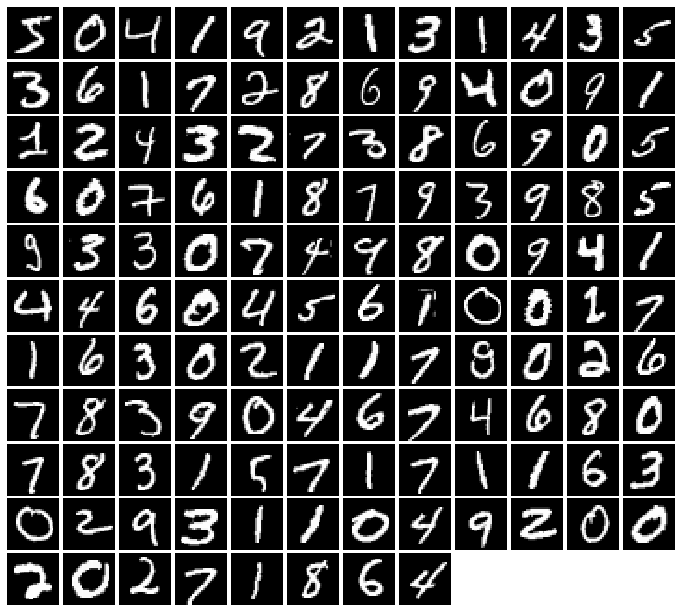

In [2]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Hint: use `torch.rand`.

In [3]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    return torch.rand(batch_size, dim) * 2 -  1


Make sure noise is the correct shape and type:

In [4]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')
    
test_sample_noise()

All tests passed!


## Flatten

Recall our Flatten operation from previous notebooks... this time we also provide an Unflatten, which you might want to use when implementing the convolutional generator. We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform(m.weight.data)

## CPU / GPU
By default all code will run on CPU. GPUs are not needed for this assignment, but will help you to train your models faster. If you do want to run the code on a GPU, then change the `dtype` variable in the following cell.

In [6]:
# dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!


# Discriminator
Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator():
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
        Flatten(),
        nn.Linear(784, 256),
        nn.LeakyReLU(),
        nn.Linear(256, 256),
        nn.LeakyReLU(),
        nn.Linear(256, 1)
    )
    return model

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. Check your achitecture.')
    else:
        print('Correct number of parameters in discriminator.')     

test_discriminator()

Correct number of parameters in discriminator.


# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * ReLU
 * Fully connected layer with size 1024 
 * ReLU
 * Fully connected layer with size 784
 * TanH
   * To clip the image to be [-1,1]

In [9]:
def generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 784)
    )
    return model

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = y * \log(s) + (1 - y) * \log(1 - s) $$

A naive implementation of this formula can be numerically unstable, so we have provided a numerically stable implementation for you below.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:


`true_labels = Variable(torch.ones(size)).type(dtype)`

Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Variable of shape (N, ) giving scores.
    - target: PyTorch Variable of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Variable containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [12]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    labels_real = torch.ones_like(logits_real).type(dtype)
    labels_fake = torch.zeros_like(logits_fake).type(dtype)
    loss = bce_loss(logits_real, labels_real) + bce_loss(logits_fake, labels_fake)
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    labels_fake = torch.ones_like(logits_fake).type(dtype)
    loss = bce_loss(logits_fake, labels_fake)
    return loss

Test your generator and discriminator loss. You should see errors < 1e-7.

In [13]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(Variable(torch.Tensor(logits_real)).type(dtype),
                                Variable(torch.Tensor(logits_fake)).type(dtype)).data.cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 3.97058e-09


In [14]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(Variable(torch.Tensor(logits_fake)).type(dtype)).data.cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 4.4518e-09


# Optimizing our loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

In [23]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
    return optimizer

# Training a GAN!

We provide you the main training loop... you won't need to change this function, but we encourage you to read through and understand it. 

In [24]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = Variable(x).type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.data.item(),g_error.data.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

/home/wangx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Iter: 0, D: 1.4, G:0.6815


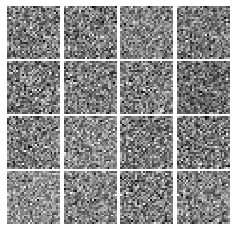


Iter: 250, D: 1.255, G:1.45


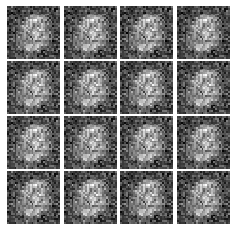


Iter: 500, D: 1.675, G:0.9094


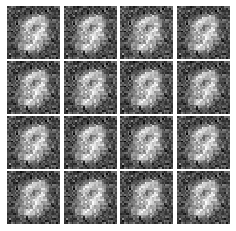


Iter: 750, D: 1.126, G:1.639


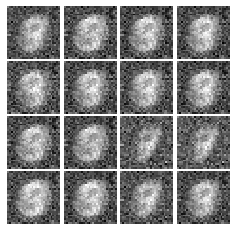


Iter: 1000, D: 1.255, G:1.267


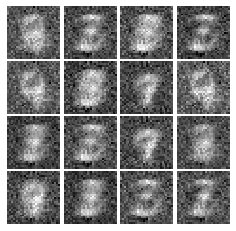


Iter: 1250, D: 1.327, G:1.027


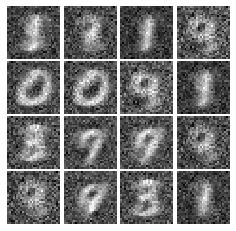


Iter: 1500, D: 1.353, G:0.9437


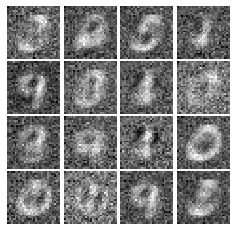


Iter: 1750, D: 1.488, G:0.7764


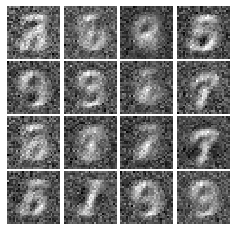


Iter: 2000, D: 1.389, G:0.9324


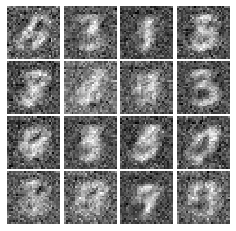


Iter: 2250, D: 1.274, G:0.7892


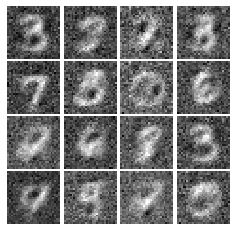


Iter: 2500, D: 1.374, G:0.8534


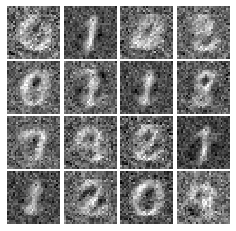


Iter: 2750, D: 1.338, G:0.7555


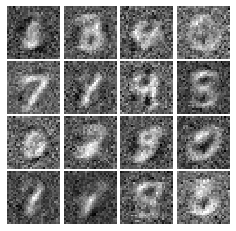


Iter: 3000, D: 1.38, G:0.7733


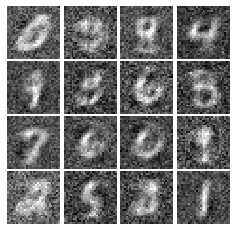


Iter: 3250, D: 1.323, G:0.7636


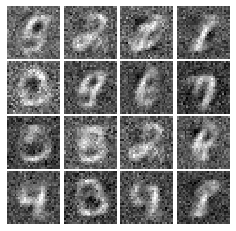


Iter: 3500, D: 1.35, G:0.7005


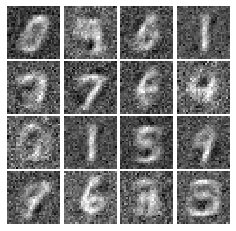


Iter: 3750, D: 1.33, G:0.6847


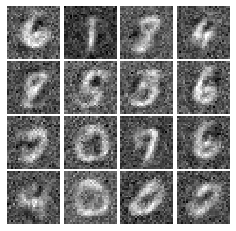

In [25]:
# Make the discriminator
D = discriminator().type(dtype)
D.apply(initialize_weights)

# Make the generator
G = generator().type(dtype)
G.apply(initialize_weights)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [26]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    loss = ((scores_real - 1)**2).mean()*0.5 + (scores_fake**2).mean()*0.5
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    loss = ((scores_fake - 1)**2).mean() * 0.5
    return loss

Before running a GAN with our new loss function, let's check it:

In [27]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    d_loss = ls_discriminator_loss(score_real, score_fake)
    g_loss = ls_generator_loss(score_fake)
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Iter: 0, D: 0.4355, G:0.4235


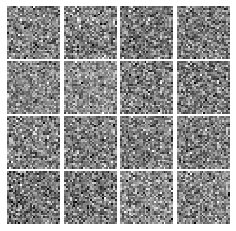


Iter: 250, D: 0.1741, G:0.498


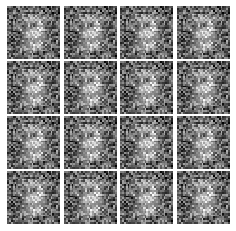


Iter: 500, D: 0.1371, G:0.3311


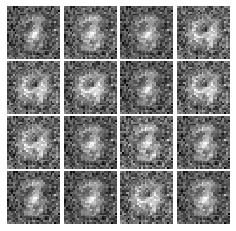


Iter: 750, D: 0.2216, G:0.2917


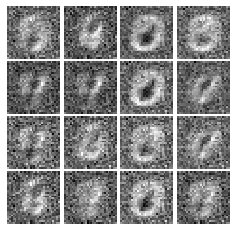


Iter: 1000, D: 0.2167, G:0.231


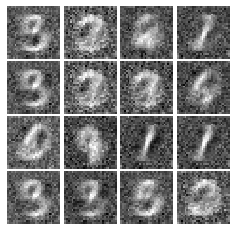


Iter: 1250, D: 0.2369, G:0.2333


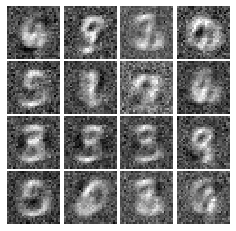


Iter: 1500, D: 0.2775, G:0.1935


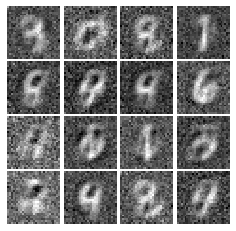


Iter: 1750, D: 0.2198, G:0.1598


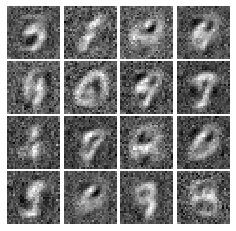


Iter: 2000, D: 0.2187, G:0.1683


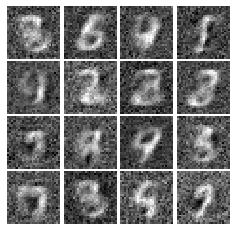


Iter: 2250, D: 0.2259, G:0.1474


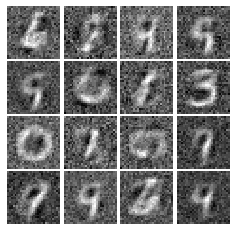


Iter: 2500, D: 0.2176, G:0.1506


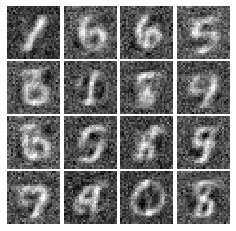


Iter: 2750, D: 0.2418, G:0.171


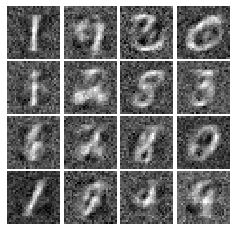


Iter: 3000, D: 0.201, G:0.1733


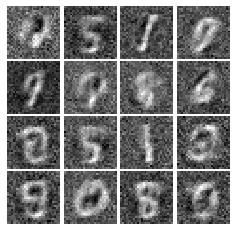


Iter: 3250, D: 0.2325, G:0.2006


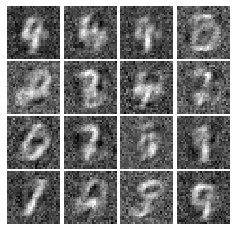


Iter: 3500, D: 0.1995, G:0.2145


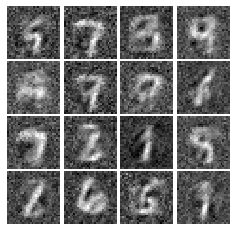


Iter: 3750, D: 0.2307, G:0.1738


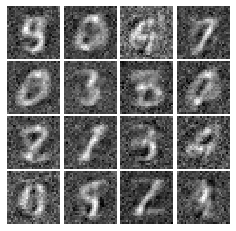

In [29]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss)

# INLINE QUESTION 1
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

TODO: YOUR ANSWER HERE

# Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks 

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Reshape into image tensor (Use Unflatten!)
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [ ]:
def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return nn.Sequential(
        ###########################
        ######### TO DO ###########
        ###########################
        Unflatten(batch_size, 1, 28, 28),
        nn.Conv2d(1, 32, (5, 5), stride=1),
        nn.LeakyReLU(),
        nn.MaxPool2d((2, 2), stride=2),
        nn.Conv2d(32, 64, (5, 5), stride=1),
        nn.LeakyReLU(),
        nn.MaxPool2d((2, 2), stride=2),
        Flatten(),
        nn.Linear(1024, 4*4*64),
        nn.LeakyReLU(),
        nn.Linear(4*4*64, 1)
    )

data = Variable(loader_train.__iter__().next()[0]).type(dtype)
b = build_dc_classifier().type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


Check the number of parameters in your classifier as a sanity check:

In [ ]:
def test_dc_classifer(true_count=1102721):
    model = build_dc_classifier()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_classifer()

Correct number of parameters in generator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode. 
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Reshape into Image Tensor
* 64 conv2d^T filters of 4x4, stride 2, 'same' padding, ReLU
* BatchNorm
* 1 conv2d^T filter of 4x4, stride 2, 'same' padding, TanH
* Should have a 28x28x1 image, reshape back into 784 vector

In [ ]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    return nn.Sequential(
        ###########################
        ######### TO DO ###########
        ###########################
        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 7*7*128),
        nn.ReLU(),
        nn.BatchNorm1d(7*7*128),
        Unflatten(),
        nn.ConvTranspose2d(128, 64, (4, 4), stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, (4, 4), stride=2, padding=1),
        nn.Tanh()
    )

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = Variable(torch.randn(batch_size, NOISE_DIM)).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

/home/wangx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


torch.Size([128, 1, 28, 28])

Check the number of parameters in your generator as a sanity check:

In [ ]:
def test_dc_generator(true_count=6580801):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


/home/wangx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Iter: 0, D: 1.481, G:0.8232


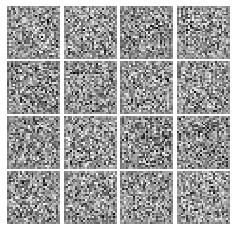


Iter: 250, D: 1.078, G:3.935


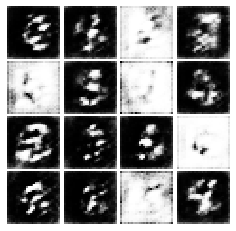


Iter: 500, D: 0.5657, G:2.522


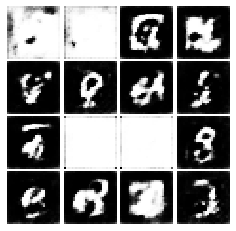


Iter: 750, D: 0.687, G:3.048


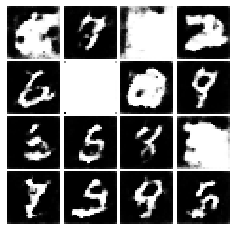


Iter: 1000, D: 0.9482, G:1.544


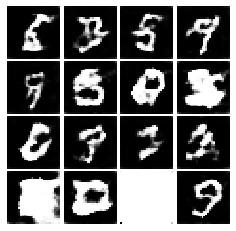


Iter: 1250, D: 1.08, G:1.94


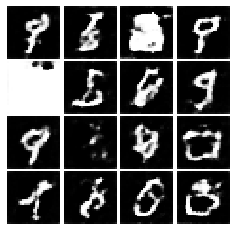


Iter: 1500, D: 0.9946, G:1.09


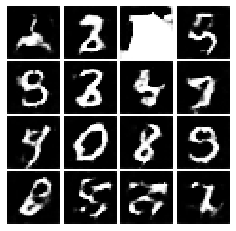


Iter: 1750, D: 0.862, G:1.48


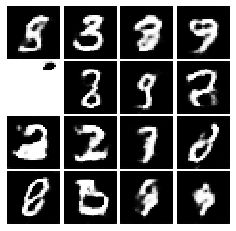


Iter: 2000, D: 0.9443, G:1.303


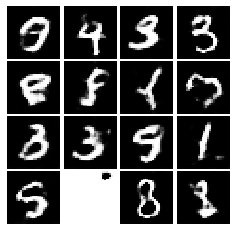


Iter: 2250, D: 1.011, G:1.15


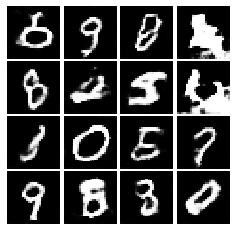


Iter: 2500, D: 1.065, G:1.373


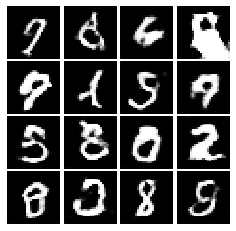


Iter: 2750, D: 1.0, G:1.349


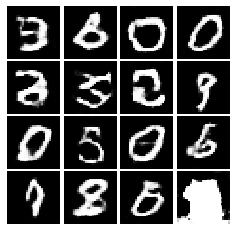


Iter: 3000, D: 1.055, G:0.9218


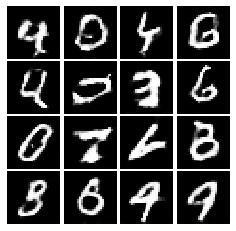


Iter: 3250, D: 1.011, G:1.192


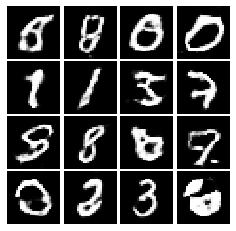


Iter: 3500, D: 1.142, G:0.6662


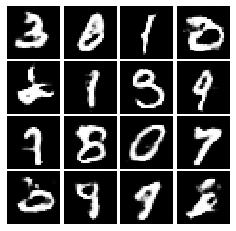


Iter: 3750, D: 1.041, G:0.8417


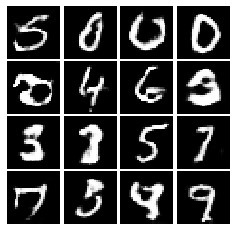


Iter: 4000, D: 1.282, G:1.331


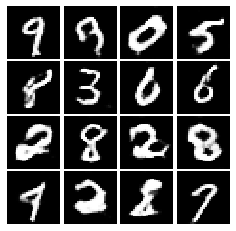


Iter: 4250, D: 1.172, G:0.6576


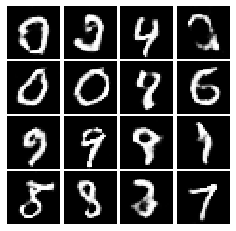


Iter: 4500, D: 1.058, G:0.9699


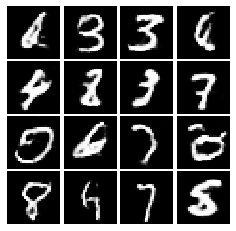


Iter: 4750, D: 1.178, G:1.069


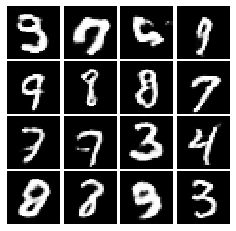


Iter: 5000, D: 1.037, G:1.18


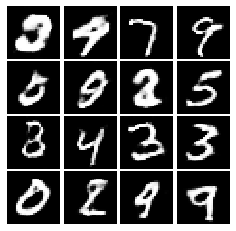


Iter: 5250, D: 1.098, G:1.277


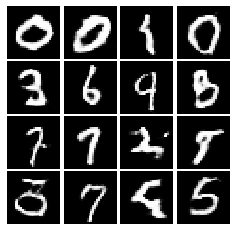


Iter: 5500, D: 1.155, G:0.7637


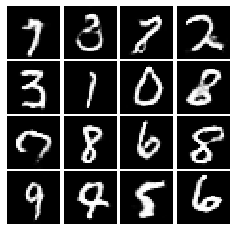


Iter: 5750, D: 1.078, G:1.097


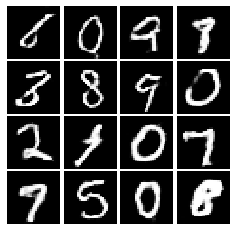


Iter: 6000, D: 1.161, G:1.366


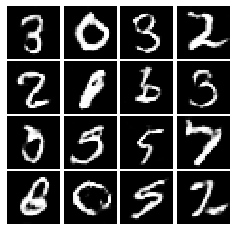


Iter: 6250, D: 1.192, G:0.9925


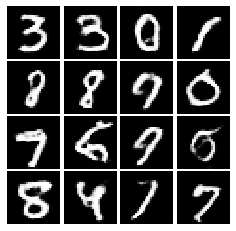


Iter: 6500, D: 1.047, G:0.8969


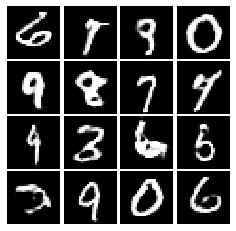


Iter: 6750, D: 0.993, G:1.655


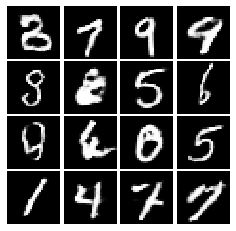


Iter: 7000, D: 1.162, G:1.06


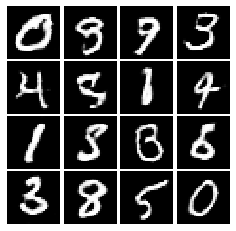


Iter: 7250, D: 1.13, G:1.144


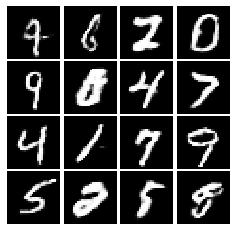


Iter: 7500, D: 1.174, G:1.227


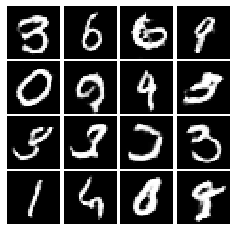


Iter: 7750, D: 1.115, G:0.854


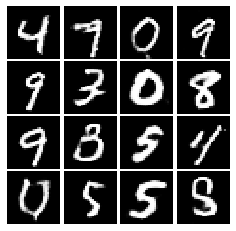


Iter: 8000, D: 1.139, G:1.055


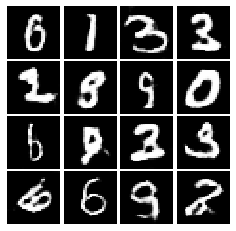


Iter: 8250, D: 1.326, G:0.8113


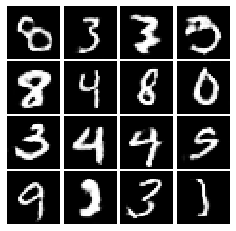


Iter: 8500, D: 1.137, G:1.022


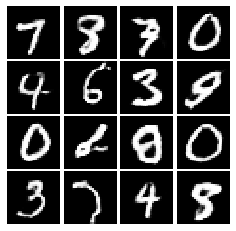


Iter: 8750, D: 1.228, G:0.8409


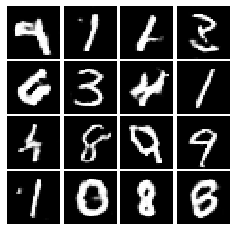


Iter: 9000, D: 1.231, G:0.7182


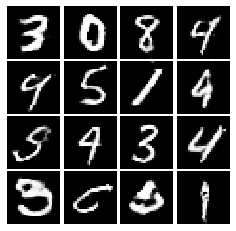


Iter: 9250, D: 1.11, G:1.55


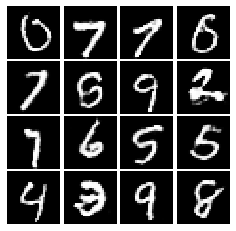


Iter: 9500, D: 1.13, G:0.9696


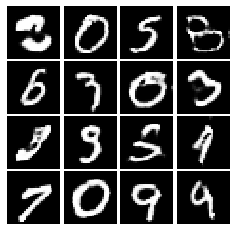


Iter: 9750, D: 1.208, G:1.544


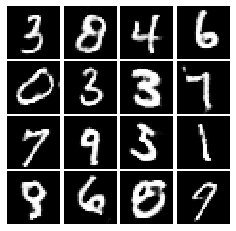


Iter: 10000, D: 1.205, G:0.716


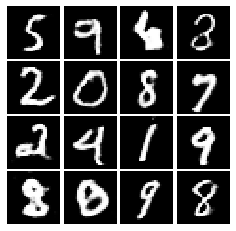


Iter: 10250, D: 1.146, G:0.8318


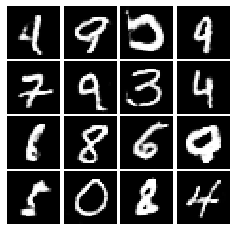


Iter: 10500, D: 1.171, G:1.433


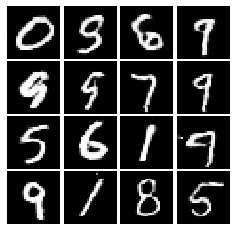


Iter: 10750, D: 1.159, G:0.9746


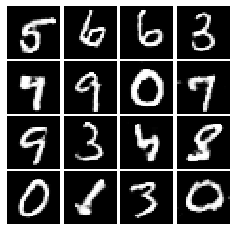


Iter: 11000, D: 1.276, G:1.156


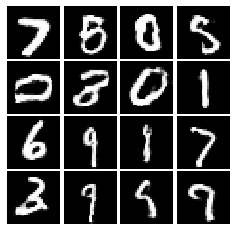


Iter: 11250, D: 1.068, G:0.9074


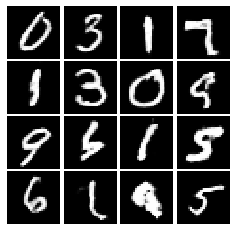


Iter: 11500, D: 1.119, G:0.8222


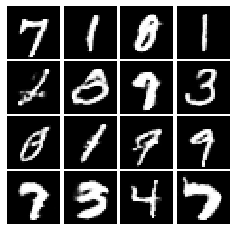


Iter: 11750, D: 1.057, G:1.146


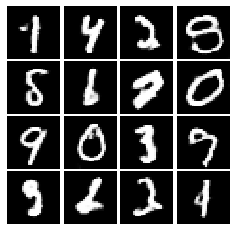


Iter: 12000, D: 1.017, G:1.171


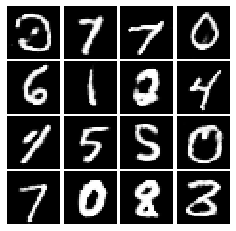


Iter: 12250, D: 1.119, G:1.087


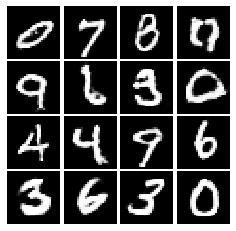


Iter: 12500, D: 1.081, G:0.7854


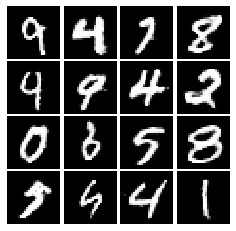


Iter: 12750, D: 1.147, G:0.8067


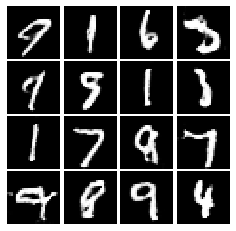


Iter: 13000, D: 1.081, G:1.053


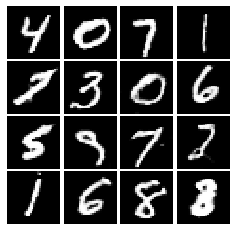


Iter: 13250, D: 1.159, G:1.12


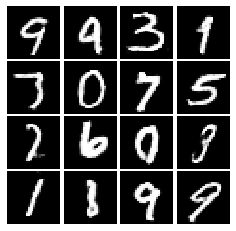


Iter: 13500, D: 1.225, G:1.427


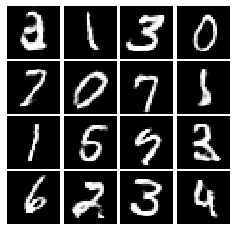


Iter: 13750, D: 1.155, G:1.103


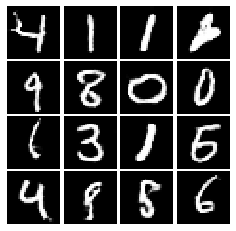

In [ ]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=50)

# INLINE QUESTION 2
What differences do you see between the DCGAN results and the original GAN results?

TODO: YOUR ANSWER HERE

## Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. 
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Something new/cool.

#### Describe what you did here
** TBD **

# WGAN
1. <https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html>
2. <https://www.pytorchtutorial.com/pytorch-improved-training-of-wasserstein-gans-wgan-gp/>

在 WGAN 中，D 的任务不再是尽力区分生成样本与真实样本，而是尽量拟合出样本间的 Wasserstein 距离，从分类任务转化成回归任务。而 G 的任务则变成了尽力缩短样本间的 Wasserstein 距离。

故 WGAN 对原始 GAN 做出了如下改变:

* D 的最后一层取消 sigmoid
* D 的 w 取值限制在 [-c,c] 区间内。
* 使用 RMSProp 或 SGD 并以较低的学习率进行优化 (论文作者在实验中得出的 trick)

## Generator
* fc --> relu --> bn
* fc --> relu --> bn
* reshape
* deconv --> relu --> bn
* deconv --> tanh

## Discriminator
* conv --> lrelu
* conv --> bn --> lrelu
* fc --> bn --> lrelu
* fc

In [53]:
def discriminator():
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
        nn.Conv2d(1, 1, (5, 5), 2, padding=2),
        nn.LeakyReLU(),
        nn.Conv2d(1, 64, (5, 5), 2, padding=2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        Flatten(),
        nn.Linear(3136, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(),
        nn.Linear(1024, 1)
    )
    return model

def generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 7*7*noise_dim*2),
        nn.ReLU(),
        nn.BatchNorm1d(7*7*noise_dim*2),
        Unflatten(C=noise_dim*2),
        nn.ConvTranspose2d(noise_dim*2, noise_dim*2, (4, 4), 2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(noise_dim*2),
        nn.ConvTranspose2d(noise_dim*2, 1, (4, 4), 2, padding=1),
        nn.Tanh()
    )
    return model

In [14]:
def wgan_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    loss = -scores_real.mean() + scores_fake.mean()
    return loss

def wgan_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    loss = -scores_fake.mean()
    return loss

In [88]:
def run_a_wgan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10, clip=0.01, critic=5):
    """
    Train a WGAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for i, (x, _) in enumerate(loader_train):
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = Variable(x).type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()
            D_solver.step()
            
            for p in D.parameters():
                p.data.clamp(-clip, clip)

            if i % critic == 0:
                G_solver.zero_grad()
                g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
                fake_images = G(g_fake_seed)

                gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
                g_error = generator_loss(gen_logits_fake)
                g_error.backward()
                G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.data.item(),g_error.data.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

In [89]:
def get_optimizer(model):
    """
    Construct and return an RMSProp optimizer for the model with learning rate 2e-4
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An RMSProp optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.RMSprop(model.parameters(), lr=2e-4)
    return optimizer

/home/wangx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Iter: 0, D: 0.0136, G:0.1094


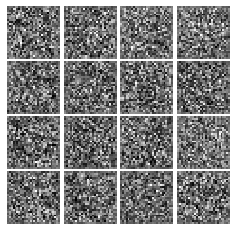


Iter: 250, D: -1.365, G:-0.1951


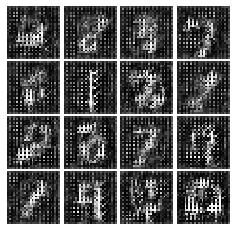


Iter: 500, D: -0.8391, G:-1.427


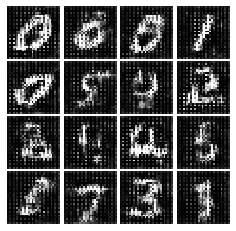


Iter: 750, D: -1.094, G:-2.187


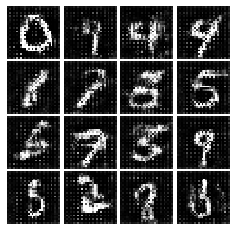


Iter: 1000, D: -0.7817, G:-2.831


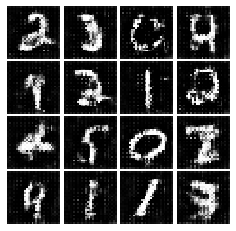


Iter: 1250, D: -1.244, G:-3.689


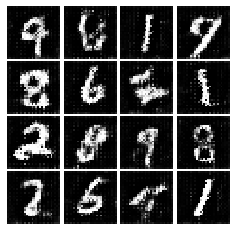


Iter: 1500, D: -1.412, G:-4.396


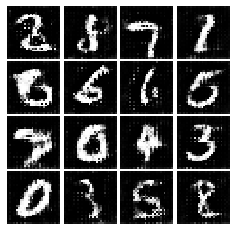


Iter: 1750, D: -1.961, G:-4.601


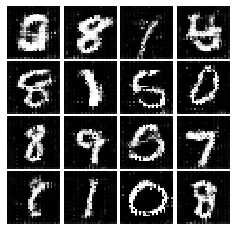


Iter: 2000, D: -0.8886, G:-5.564


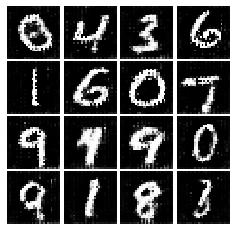


Iter: 2250, D: -1.196, G:-6.324


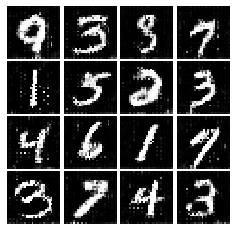


Iter: 2500, D: -1.555, G:-6.669


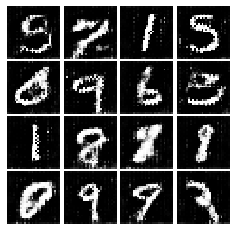


Iter: 2750, D: -1.777, G:-7.985


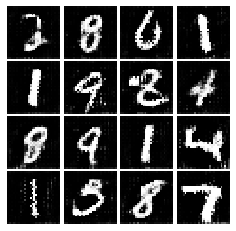


Iter: 3000, D: -1.846, G:-8.144


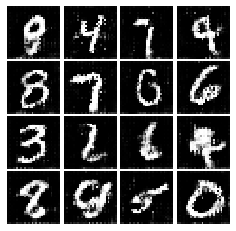


Iter: 3250, D: -2.629, G:-9.129


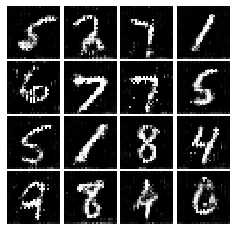


Iter: 3500, D: -2.688, G:-8.8


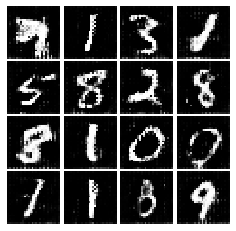


Iter: 3750, D: -2.796, G:-9.181


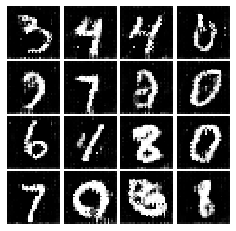


Iter: 4000, D: -2.366, G:-10.77


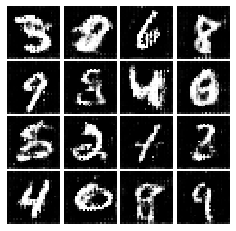


Iter: 4250, D: -2.872, G:-11.59


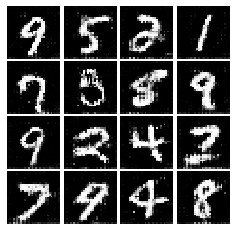


Iter: 4500, D: -2.421, G:-13.32


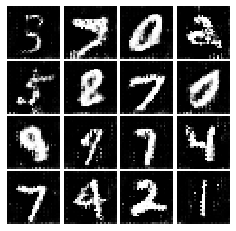


Iter: 4750, D: -2.931, G:-12.57


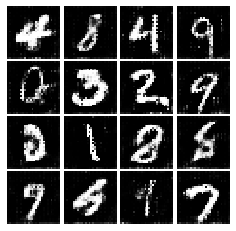


Iter: 5000, D: -3.093, G:-13.68


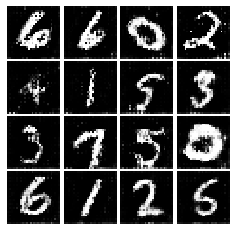


Iter: 5250, D: -2.628, G:-13.42


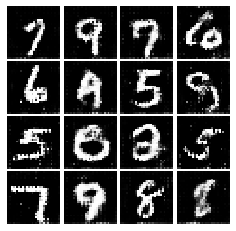


Iter: 5500, D: -4.833, G:-15.54


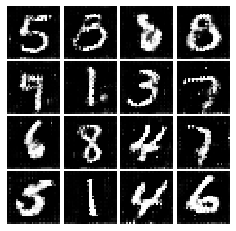


Iter: 5750, D: -4.089, G:-16.6


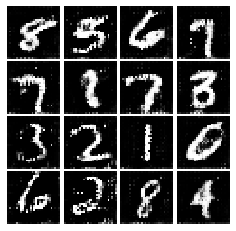


Iter: 6000, D: -3.105, G:-15.59


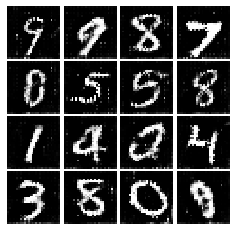


Iter: 6250, D: -4.073, G:-15.87


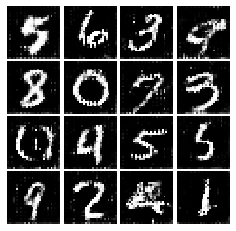


Iter: 6500, D: -8.027, G:-16.9


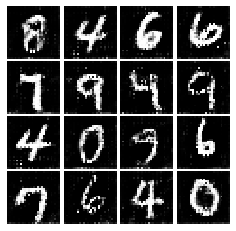


Iter: 6750, D: -5.734, G:-18.21


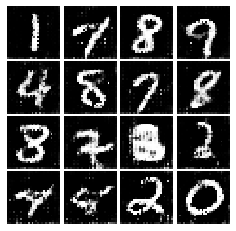


Iter: 7000, D: -3.233, G:-19.68


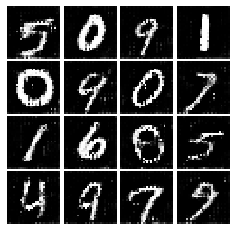


Iter: 7250, D: -4.993, G:-20.01


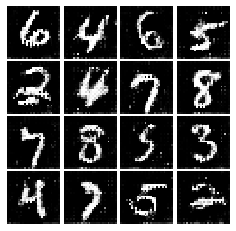


Iter: 7500, D: -4.341, G:-20.89


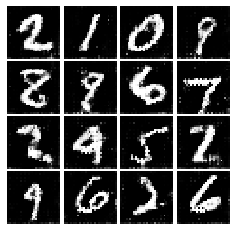


Iter: 7750, D: -6.096, G:-21.58


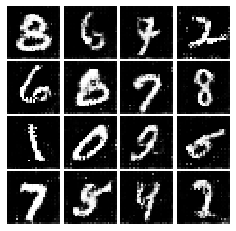


Iter: 8000, D: -8.183, G:-21.65


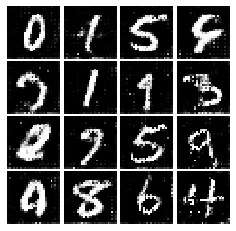


Iter: 8250, D: -11.2, G:-22.49


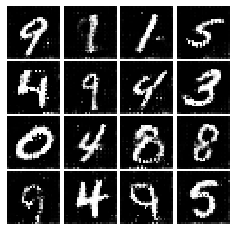


Iter: 8500, D: -7.991, G:-25.98


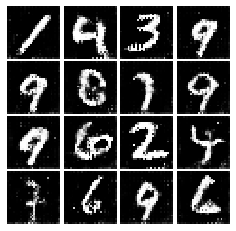


Iter: 8750, D: -10.13, G:-24.46


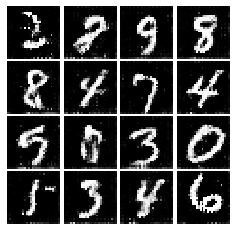


Iter: 9000, D: -8.898, G:-25.07


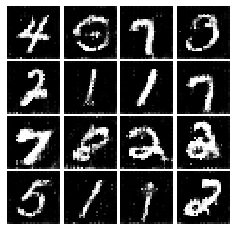


Iter: 9250, D: -8.899, G:-25.2


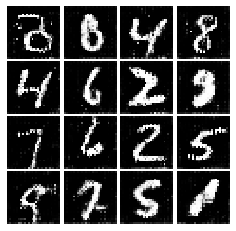


Iter: 9500, D: -9.441, G:-26.7


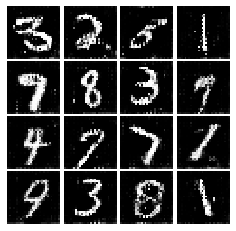


Iter: 9750, D: -7.153, G:-28.28


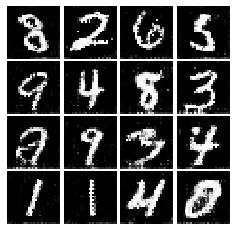


Iter: 10000, D: -10.03, G:-26.78


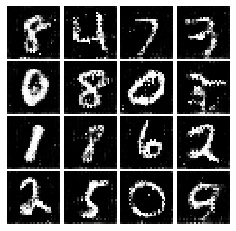


Iter: 10250, D: -13.01, G:-27.2


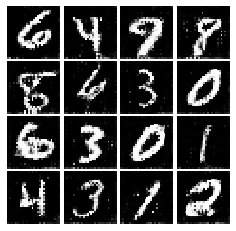


Iter: 10500, D: -12.2, G:-28.95


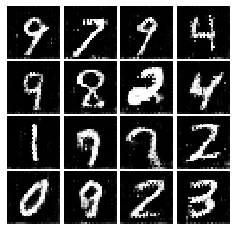


Iter: 10750, D: -13.42, G:-29.98


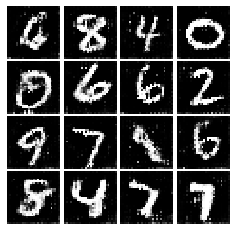


Iter: 11000, D: -12.08, G:-31.72


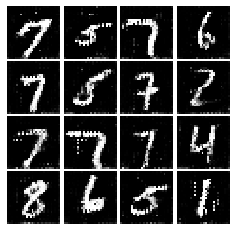


Iter: 11250, D: -14.27, G:-33.59


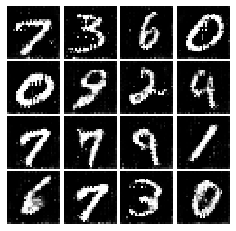


Iter: 11500, D: -14.21, G:-31.85


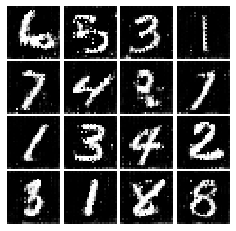


Iter: 11750, D: -14.31, G:-35.55


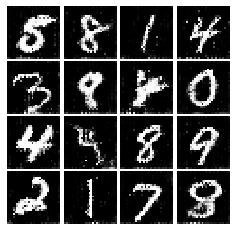


Iter: 12000, D: -10.88, G:-36.39


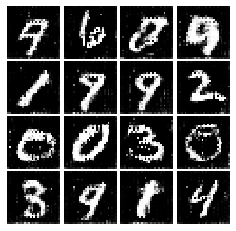


Iter: 12250, D: -13.43, G:-33.37


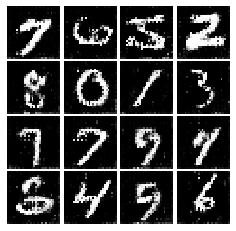


Iter: 12500, D: -16.0, G:-34.19


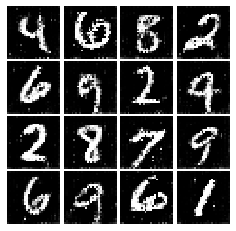


Iter: 12750, D: -27.92, G:-32.3


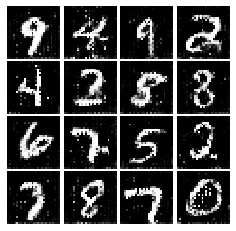


Iter: 13000, D: -24.6, G:-32.06


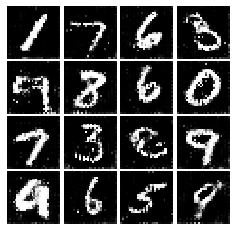


Iter: 13250, D: -26.66, G:-33.58


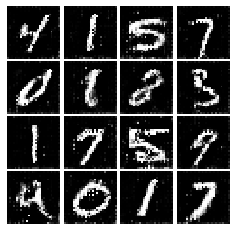


Iter: 13500, D: -29.63, G:-35.28


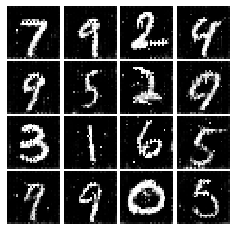


Iter: 13750, D: -25.76, G:-36.69


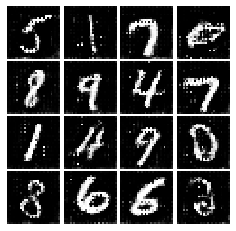


Iter: 14000, D: -27.51, G:-41.08


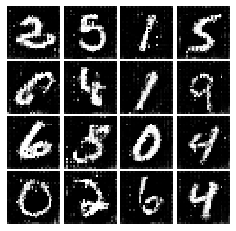


Iter: 14250, D: -28.1, G:-34.8


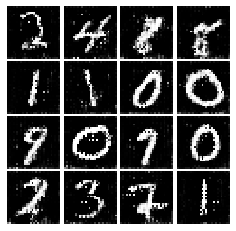


Iter: 14500, D: -26.99, G:-37.09


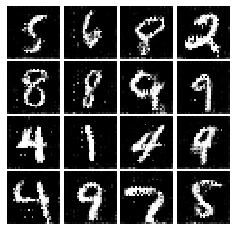


Iter: 14750, D: -25.07, G:-44.61


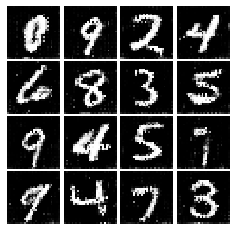


Iter: 15000, D: -26.04, G:-39.66


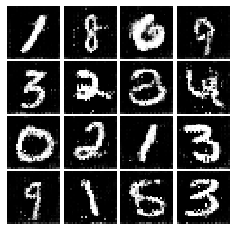


Iter: 15250, D: -28.63, G:-37.29


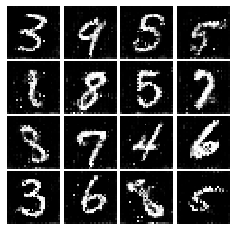


Iter: 15500, D: -40.33, G:-37.64


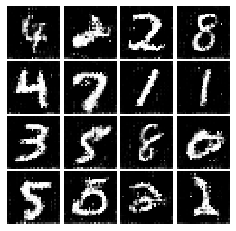


Iter: 15750, D: -33.91, G:-37.34


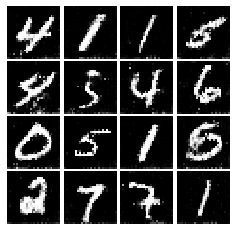


Iter: 16000, D: -34.86, G:-35.27


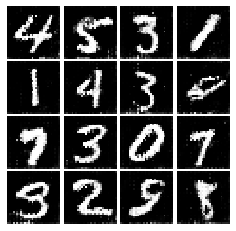


Iter: 16250, D: -53.12, G:-31.25


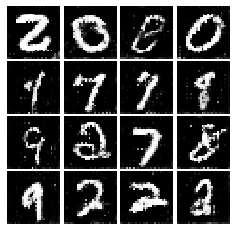


Iter: 16500, D: -44.99, G:-31.69


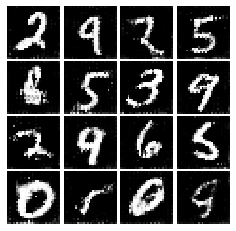


Iter: 16750, D: -42.91, G:-35.28


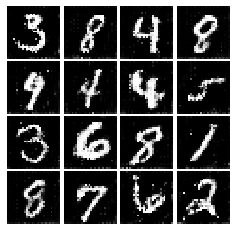


Iter: 17000, D: -45.2, G:-34.99


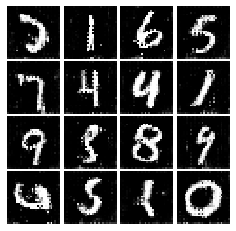


Iter: 17250, D: -42.86, G:-41.07


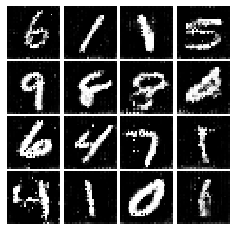


Iter: 17500, D: -41.91, G:-40.38


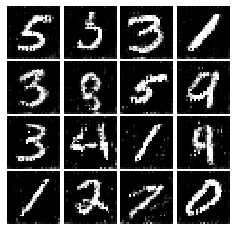


Iter: 17750, D: -47.64, G:-37.1


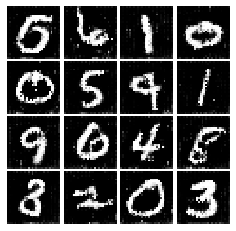


Iter: 18000, D: -58.91, G:-43.42


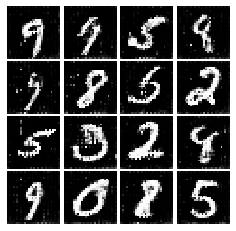


Iter: 18250, D: -59.0, G:-42.43


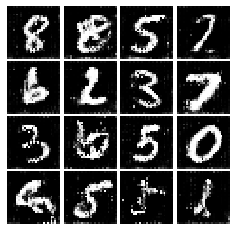


Iter: 18500, D: -67.11, G:-31.29


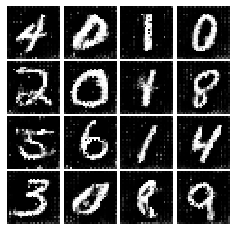


Iter: 18750, D: -52.01, G:-34.23


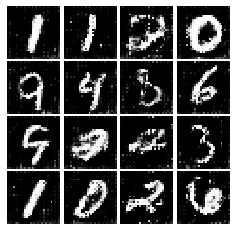


Iter: 19000, D: -58.1, G:-33.95


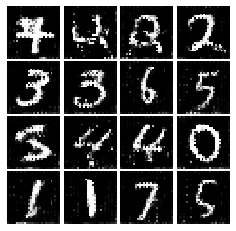


Iter: 19250, D: -48.14, G:-36.09


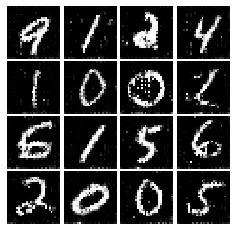

In [90]:
D = discriminator().type(dtype) 
D.apply(initialize_weights)
G = generator().type(dtype)
G.apply(initialize_weights)

D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

run_a_gan(D, G, D_solver, G_solver, 
    wgan_discriminator_loss, wgan_generator_loss, num_epochs=50)

# WGAN-GP

![img](https://www.pytorchtutorial.com/wp-content/uploads/2017/08/b6ee686067d04ab3ac69466ed6c6f2d5_th.jpeg)


由于在WGAN中使用权重剪枝可能会导致不良结果，研究者考虑在训练目标上使用Lipschitz约束的一种替代方法：一个可微的函数是1-Lipschitz，当且仅当它的梯度具有小于或等于1的范数时。因此，可以直接约束critic函数对其输入的梯度范数。新的critic函数为：


$$
L = \mathbb{E}_{\tilde{x}\sim \mathbb{P}_g} [D(\tilde{x})] 
- \mathbb{E}_{x\sim \mathbb{P}_r} [D(x)] 
+ \lambda\mathbb{E}_{\hat{x}\sim\mathbb{P}_{\hat{x}}}[(||\bigtriangledown_{\hat{x}}D(\hat{x})||_2 - 1)^2]
$$

## Tips

1. No batch normlization in generator and discriminator
2. User `torch.autograd.grad` to compute gradient of $\hat{x}$

## Reference

1. <https://www.pytorchtutorial.com/pytorch-improved-training-of-wasserstein-gans-wgan-gp/>
2. <https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490>


In [49]:
def discriminator():
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
        nn.Conv2d(1, 1, (5, 5), 2, padding=2),
        nn.LeakyReLU(),
        nn.Conv2d(1, 64, (5, 5), 2, padding=2),
        nn.LeakyReLU(),
        Flatten(),
        nn.Linear(3136, 1024),
        nn.LeakyReLU(),
        nn.Linear(1024, 1)
    )
    return model

def generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.Linear(1024, 7*7*noise_dim*2),
        nn.ReLU(),
        Unflatten(C=noise_dim*2),
        nn.ConvTranspose2d(noise_dim*2, noise_dim*2, (4, 4), 2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(noise_dim*2, 1, (4, 4), 2, padding=1),
        nn.Tanh()
    )
    return model

In [54]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-4,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.999))
    return optimizer

In [72]:
def compute_gradient_penalty(D, real_samples, fake_samples, dtype):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).type(dtype)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    interpolates = interpolates.type(dtype)
    d_interpolates = D(interpolates)
    fake = Variable(torch.Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False).type(dtype)
    # Get gradient w.r.t. interpolates
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [73]:
def run_a_wgan_gp(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10, critic=5, lambda_gp=10.):
    """
    Train a WGAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    alpha = torch.empty(batch_size, 1, 1, 1).type(dtype)
    iter_count = 0
    for epoch in range(num_epochs):
        for i, (x, _) in enumerate(loader_train):
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = Variable(x).type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
     
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(D, real_data, fake_images, dtype)
            d_total_error = discriminator_loss(logits_real, logits_fake) + \
                lambda_gp * gradient_penalty
                    
            d_total_error.backward()
            D_solver.step()

            if i % critic == 0:
                G_solver.zero_grad()
                g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
                fake_images = G(g_fake_seed)

                gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
                g_error = generator_loss(gen_logits_fake)
                g_error.backward()
                G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.data.item(),g_error.data.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

/home/wangx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Iter: 0, D: 1.745, G:0.3191


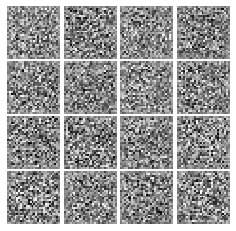


Iter: 250, D: -0.03805, G:0.244


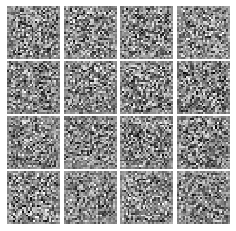


Iter: 500, D: -0.1941, G:0.3576


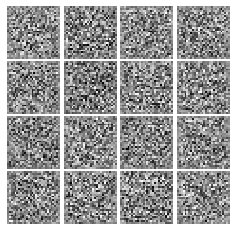


Iter: 750, D: -0.6016, G:0.8185


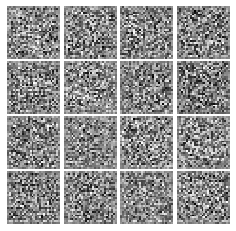


Iter: 1000, D: -0.8023, G:1.271


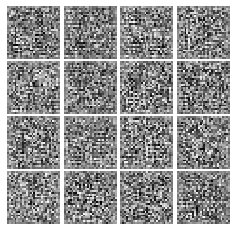


Iter: 1250, D: -0.7384, G:1.567


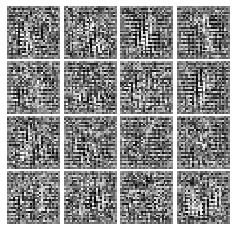


Iter: 1500, D: -1.114, G:1.893


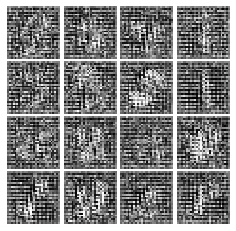


Iter: 1750, D: -1.783, G:2.09


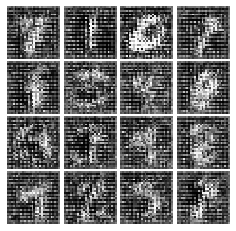


Iter: 2000, D: -2.0, G:2.306


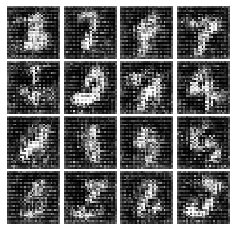


Iter: 2250, D: -2.563, G:2.376


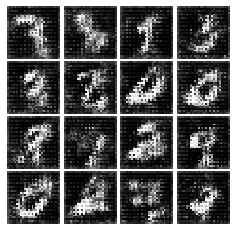


Iter: 2500, D: -3.436, G:2.303


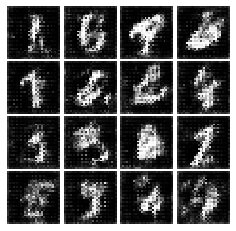


Iter: 2750, D: -3.337, G:0.9365


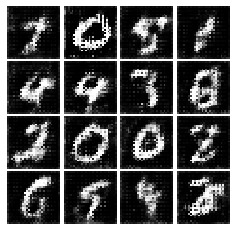


Iter: 3000, D: -3.522, G:1.919


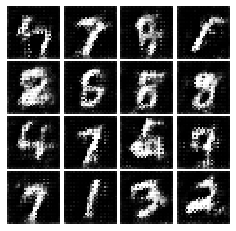


Iter: 3250, D: -3.995, G:2.038


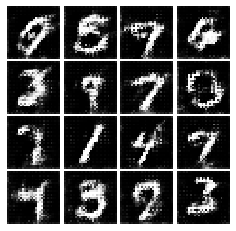


Iter: 3500, D: 5.069, G:3.206


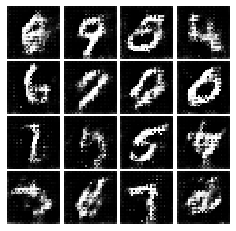


Iter: 3750, D: 0.1424, G:4.099


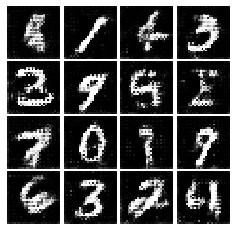


Iter: 4000, D: -0.1189, G:3.152


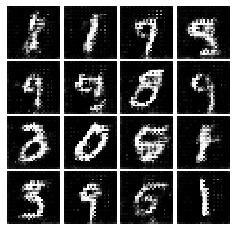


Iter: 4250, D: -1.079, G:2.831


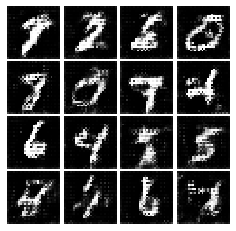


Iter: 4500, D: -1.961, G:2.906


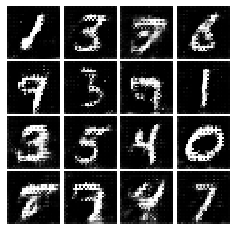


Iter: 4750, D: -1.992, G:3.641


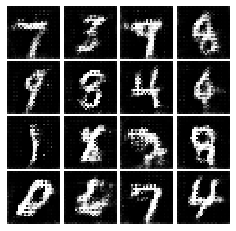


Iter: 5000, D: -1.971, G:4.051


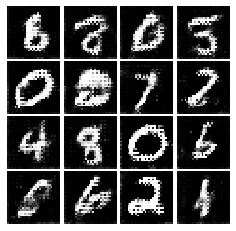


Iter: 5250, D: -2.115, G:4.266


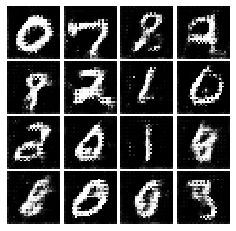


Iter: 5500, D: -2.604, G:4.658


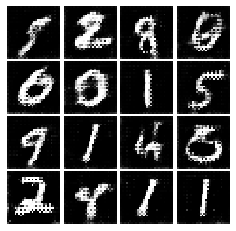


Iter: 5750, D: -2.293, G:5.556


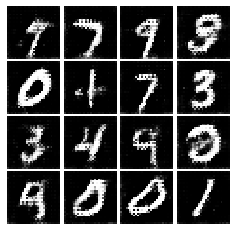


Iter: 6000, D: -2.577, G:6.237


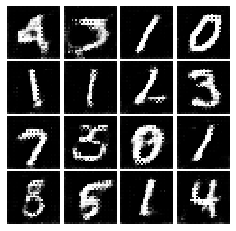


Iter: 6250, D: -2.231, G:6.462


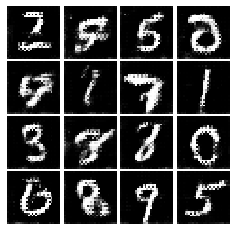


Iter: 6500, D: -3.46, G:7.078


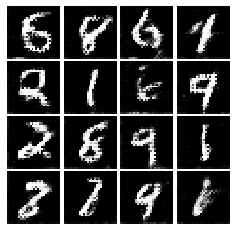


Iter: 6750, D: -3.861, G:6.597


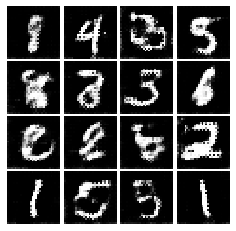


Iter: 7000, D: -3.469, G:6.563


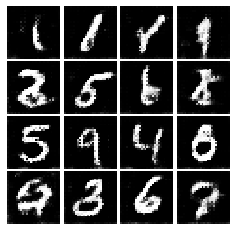


Iter: 7250, D: -3.962, G:6.389


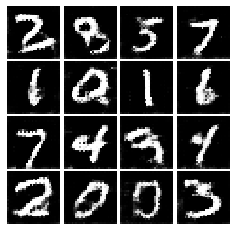


Iter: 7500, D: -3.026, G:4.879


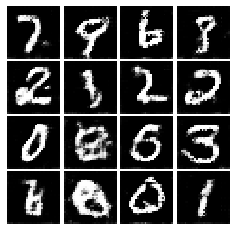


Iter: 7750, D: -4.461, G:5.238


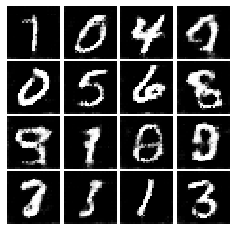


Iter: 8000, D: -4.2, G:5.149


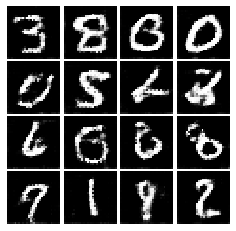


Iter: 8250, D: -5.023, G:4.882


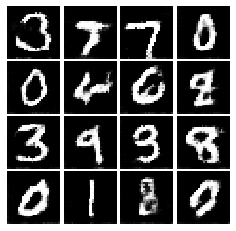


Iter: 8500, D: -4.54, G:4.251


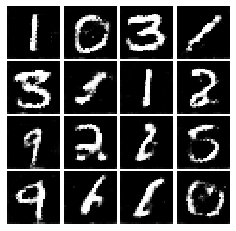


Iter: 8750, D: -3.983, G:2.979


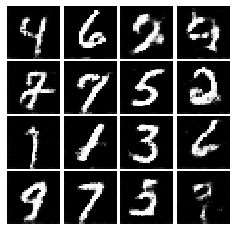


Iter: 9000, D: -4.234, G:2.829


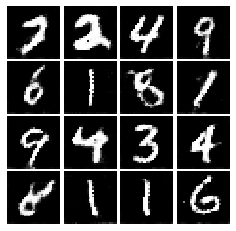


Iter: 9250, D: -4.773, G:3.073


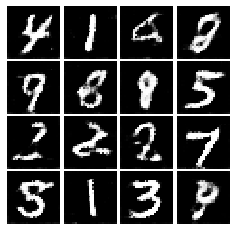


Iter: 9500, D: -5.268, G:2.727


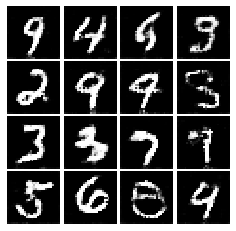


Iter: 9750, D: -5.182, G:1.497


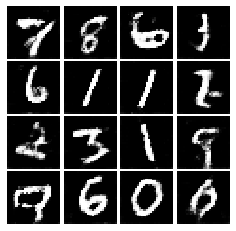


Iter: 10000, D: -3.645, G:1.077


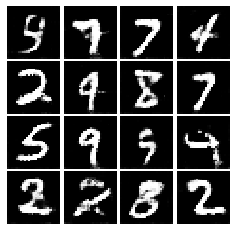


Iter: 10250, D: -5.211, G:0.3624


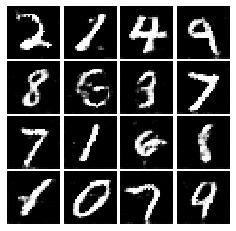


Iter: 10500, D: -6.217, G:0.3729


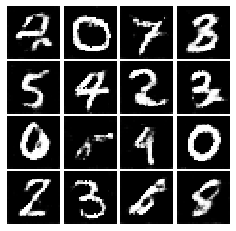


Iter: 10750, D: -6.994, G:0.4287


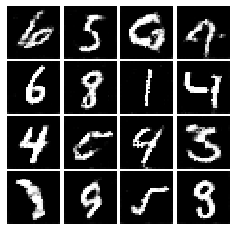


Iter: 11000, D: -4.002, G:-1.741


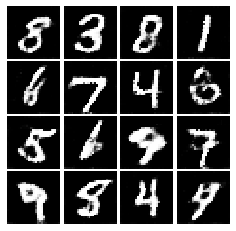


Iter: 11250, D: -7.342, G:-1.33


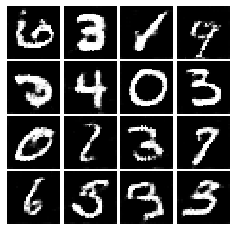


Iter: 11500, D: -7.922, G:-1.332


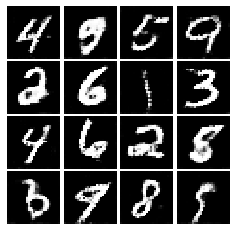


Iter: 11750, D: -8.313, G:-2.995


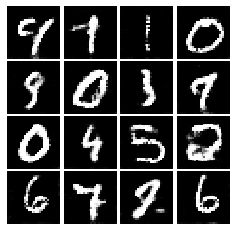


Iter: 12000, D: -6.12, G:-2.849


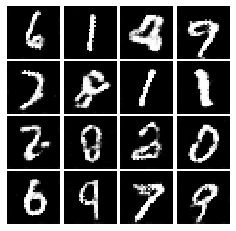


Iter: 12250, D: -6.189, G:-3.795


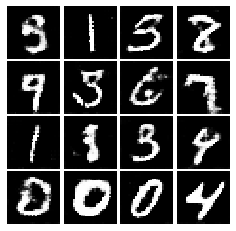


Iter: 12500, D: -7.629, G:-2.128


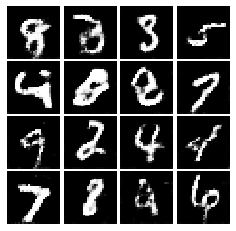


Iter: 12750, D: -6.312, G:-2.422


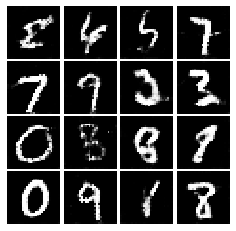


Iter: 13000, D: -8.924, G:-3.53


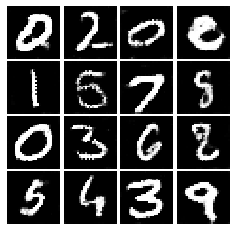


Iter: 13250, D: -7.206, G:-3.251


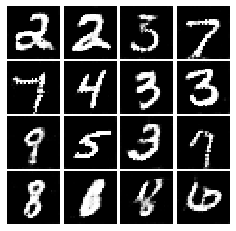


Iter: 13500, D: -8.932, G:-1.725


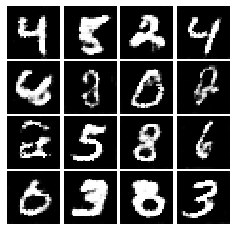


Iter: 13750, D: -7.08, G:-4.015


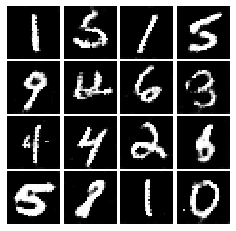


Iter: 14000, D: -6.902, G:-1.947


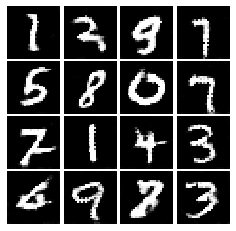


Iter: 14250, D: -10.5, G:-2.284


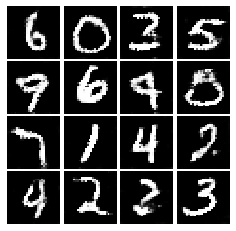


Iter: 14500, D: -10.53, G:-3.219


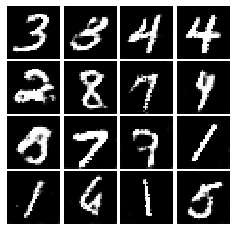


Iter: 14750, D: -8.805, G:-0.7785


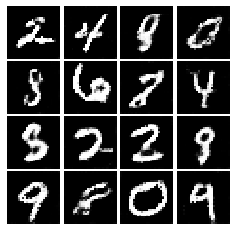


Iter: 15000, D: -8.763, G:-1.27


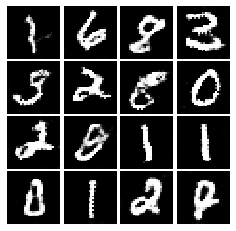


Iter: 15250, D: -11.14, G:-2.29


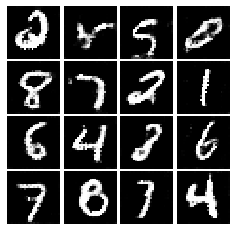


Iter: 15500, D: -9.147, G:0.3601


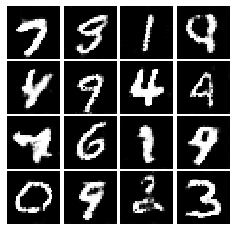


Iter: 15750, D: -9.017, G:-2.17


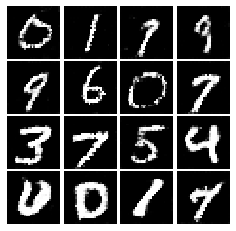


Iter: 16000, D: -6.149, G:-0.2457


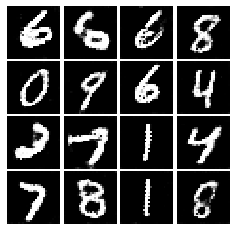


Iter: 16250, D: -11.08, G:-0.4539


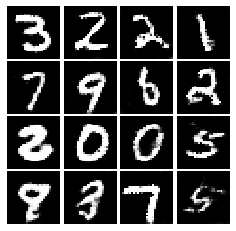


Iter: 16500, D: -14.1, G:0.2272


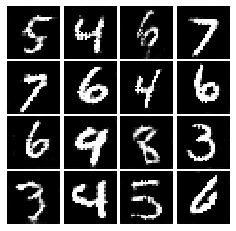


Iter: 16750, D: -12.65, G:1.279


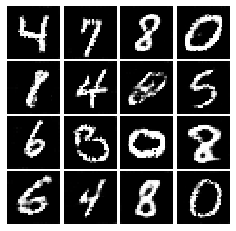


Iter: 17000, D: -14.73, G:-0.4223


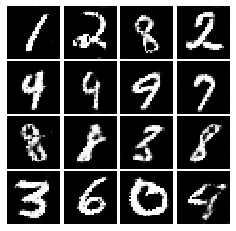


Iter: 17250, D: -8.577, G:-2.017


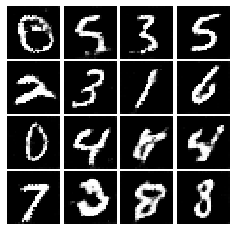


Iter: 17500, D: -12.31, G:0.4091


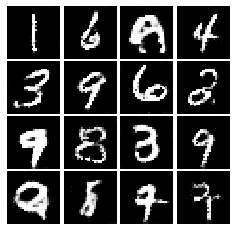


Iter: 17750, D: -13.08, G:0.1951


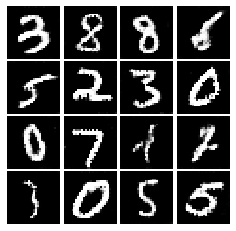


Iter: 18000, D: -19.07, G:-0.1657


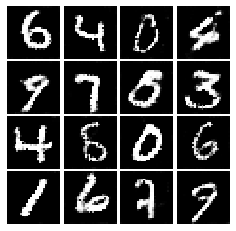


Iter: 18250, D: -14.68, G:1.841


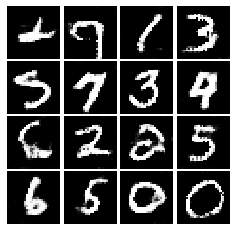


Iter: 18500, D: -17.26, G:-0.2053


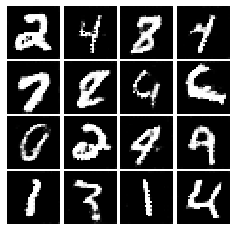


Iter: 18750, D: -10.09, G:-1.503


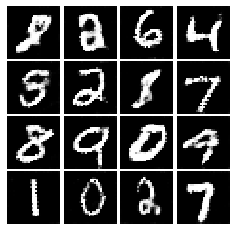


Iter: 19000, D: -12.98, G:5.244


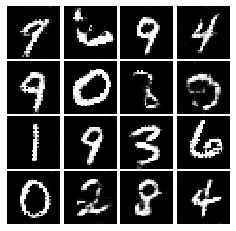


Iter: 19250, D: -12.1, G:2.807


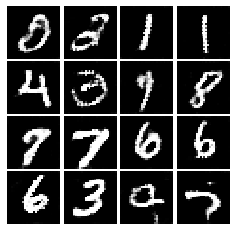

In [74]:
D = discriminator().type(dtype) 
D.apply(initialize_weights)
G = generator().type(dtype)
G.apply(initialize_weights)

D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

run_a_wgan_gp(D, G, D_solver, G_solver, 
    wgan_discriminator_loss, wgan_generator_loss, num_epochs=50)